In [131]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kdrama/kdrama.xlsx


In [132]:
import re
import networkx as nx
import time
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

In [133]:
kdrama = pd.read_excel("/kaggle/input/kdrama/kdrama.xlsx")
kdrama.head(5)

,Title,Description,Genres,Director,Screenwriter,Tags,Episodes,Aired,Aired On,Original Network,Score,User_rated,Watchers,Ranked,Popularity,Casts
0,Hospital Playlist,A drama depicting the stories of people going ...,"['Friendship', 'Music', 'Comedy', 'Romance', '...",['Shin Won Ho'],['Lee Woo Jung'],"['Strong Friendship', 'Doctor', 'Multiple Main...",12,"Mar 12, 2020 - May 28, 2020",Thursday,"tvN,Netflix",9.3,3578,10789,12,377,"['Jo Jung Suk', 'Yoo Yeon Seok', 'Jung Kyung H..."
1,Prison Playbook,"Kim Je Hyuk, a famous baseball player, is arre...","['Friendship', 'Comedy', 'Life', 'Drama']",['Shin Won Ho'],"['Jung Bo Hoon', 'Lee Woo Jung']","['Prison', 'Bromance', 'Slight Romance', 'Blac...",16,"Nov 22, 2017 - Jan 18, 2018","Wednesday, Thursday","tvN,Netflix",9.2,8208,21468,21,130,"['Park Hae Soo', 'Jung Kyung Ho']"
2,My Mister,Park Dong Hoon is a middle-aged engineer who i...,"['Business', 'Psychological', 'Life', 'Drama',...",['Kim Won Suk'],['Park Hae Young'],"['Nice Male Lead', 'Healing', 'Strong Female L...",16,"Mar 21, 2018 - May 17, 2018","Wednesday, Thursday",tvN,9.2,7591,20089,22,148,"['Lee Sun Kyun', 'IU']"
3,Signal,"Fifteen years ago, a young girl was kidnapped ...","['Suspense', 'Mystery', 'Crime', 'Drama', 'Sup...",['Kim Won Suk'],['Kim Eun Hee'],"['Different Timelines', 'Criminal Profiler', '...",16,"Jan 22, 2016 - Mar 12, 2016","Friday, Saturday",tvN,9.2,14852,33538,23,49,"['Lee Je Hoon', 'Kim Hye Soo', 'Jo Jin Woong']"
4,Mother,"Realizing one of her students is being abused,...","['Suspense', 'Psychological', 'Life', 'Drama',...","['Kim Cheol Kyu', 'Yoon Hyun Gi']",['Jung Seo Kyung'],"['Mother-Daughter Relationship', 'Independent ...",16,"Jan 24, 2018 - Mar 15, 2018","Wednesday, Thursday",tvN,9.2,4200,12588,28,314,"['Lee Bo Young', 'Heo Yool']"


In [134]:
kdrama.isnull().sum()

Title                 0
Description           0
Genres                0
Director              0
Screenwriter          0
Tags                  0
Episodes              0
Aired                 1
Aired On            148
Original Network    124
Score                 0
User_rated            0
Watchers              0
Ranked                0
Popularity            0
Casts                 0
dtype: int64

In [135]:
kdrama.loc[kdrama['Aired'].isnull()]

,Title,Description,Genres,Director,Screenwriter,Tags,Episodes,Aired,Aired On,Original Network,Score,User_rated,Watchers,Ranked,Popularity,Casts
643,M2020,"""M2020"" is a remake of 1994 ""M - Drama"", starr...","['Thriller', 'Horror', 'Drama']",[],[],"['Remake', 'Vengeance']",0,NaN,NaN,NaN,0.0,0,29,26001,99999,[]


In [136]:
#since there isnt much information about M2020 and it is upcoming drama, we can drop it
kdrama = kdrama.loc[~kdrama['Aired'].isnull()]
kdrama.isnull().sum()

Title                 0
Description           0
Genres                0
Director              0
Screenwriter          0
Tags                  0
Episodes              0
Aired                 0
Aired On            147
Original Network    123
Score                 0
User_rated            0
Watchers              0
Ranked                0
Popularity            0
Casts                 0
dtype: int64

In [137]:
month_dict = {
    'Jan' : 1,
    'Feb' : 2,
    'Mar' : 3,
    'Apr' : 4,
    'May' : 5,
    'Jun' : 6,
    'Jul' : 7,
    'Aug' : 8,
    'Sep' : 9,
    'Oct' : 10,
    'Nov' : 11,
    'Dec' : 12
}

def parse_aired_date(str_date):
    try:
        found = re.findall("([A-Za-z]+)  ?(\d{1,2}), (\d{4})", str_date)
        found = found[-1]
        month = found[0]
        year = found[2]
    except:
        try:
            found = re.findall("([A-Za-z]+), (\d{4})", str_date)
            found = found[-1]
            month = found[0]
            year = found[1]
        except:
            try:
                found = re.findall("(\d{4})", str_date)
                month = None
                year = found[-1]
            except:
                month = None
                year = None
    return (month, year)

In [138]:
month = []
year = []

for aired in kdrama["Aired"]:
    try:
        stamp = parse_aired_date(aired)
        month.append(stamp[0])
        year.append(stamp[1])
    except:
        print(aired)
month = list(map(month_dict.get,month))
kdrama['Aired Month'] = pd.Series(data=month)
kdrama['Aired Year']= pd.Series(data=year)

In [139]:
from ast import literal_eval
kdrama['Genres'] = kdrama['Genres'].apply(lambda x: literal_eval(x))
kdrama['Director'] = kdrama['Director'].apply(lambda x: literal_eval(x))
kdrama['Screenwriter'] = kdrama['Screenwriter'].apply(lambda x: literal_eval(x))
kdrama['Casts'] = kdrama['Casts'].apply(lambda x: literal_eval(x))
kdrama['Tags'] = kdrama['Tags'].apply(lambda x: literal_eval(x))

In [140]:
kdrama.head(2)

,Title,Description,Genres,Director,Screenwriter,Tags,Episodes,Aired,Aired On,Original Network,Score,User_rated,Watchers,Ranked,Popularity,Casts,Aired Month,Aired Year
0,Hospital Playlist,A drama depicting the stories of people going ...,"[Friendship, Music, Comedy, Romance, Life, Dra...",[Shin Won Ho],[Lee Woo Jung],"[Strong Friendship, Doctor, Multiple Mains, Sl...",12,"Mar 12, 2020 - May 28, 2020",Thursday,"tvN,Netflix",9.3,3578,10789,12,377,"[Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Ki...",5.0,2020
1,Prison Playbook,"Kim Je Hyuk, a famous baseball player, is arre...","[Friendship, Comedy, Life, Drama]",[Shin Won Ho],"[Jung Bo Hoon, Lee Woo Jung]","[Prison, Bromance, Slight Romance, Black Comed...",16,"Nov 22, 2017 - Jan 18, 2018","Wednesday, Thursday","tvN,Netflix",9.2,8208,21468,21,130,"[Park Hae Soo, Jung Kyung Ho]",1.0,2018


In [141]:
kdrama['Original Network'][0].split(',')

['tvN', 'Netflix']

In [142]:
def parse_original_network(x):
    try:
        x= x.split(',')
    except:
        x = list()
    return x

def parse_aired_on(x):
    try:
        x= x.split()
        p = re.compile(',')
        for i in range(len(x)):
            x[i] = p.sub('', x[i])
    except:
        x = list()
    return x

kdrama['Original Network'] = kdrama['Original Network'].apply(parse_original_network)
kdrama['Aired On'] = kdrama['Aired On'].apply(parse_aired_on)

In [143]:
def filter_frequent_items(x, frequent_items_list):
    x = [e for e in x if e in frequent_items_list]
    return x

In [144]:
filter_col = ['Director', 'Screenwriter', 'Genres', 'Tags', 'Original Network', 'Casts']

for col in filter_col:
    items_count = pd.Series(data = kdrama[col].sum())
    print("{} counts (before filter): {}" .format(col,len(items_count)))
    items_count = items_count.value_counts()>1
    items_count = items_count[items_count].index
    kdrama[col] = kdrama[col].apply(filter_frequent_items, args=(items_count,))
    print("{} counts (after filter): {}".format(col,len(items_count)))
    print("\n")

Director counts (before filter): 525
Director counts (after filter): 152


Screenwriter counts (before filter): 502
Screenwriter counts (after filter): 119


Genres counts (before filter): 3299
Genres counts (after filter): 41


Tags counts (before filter): 5508
Tags counts (after filter): 590


Original Network counts (before filter): 1297
Original Network counts (after filter): 26


Casts counts (before filter): 2730
Casts counts (after filter): 681




In [145]:
BIN_NO = 10
kdrama['Episodes'] = pd.qcut(kdrama['Episodes'], BIN_NO, labels=False, duplicates = 'drop') #9 bins
kdrama['Ranked'] =pd.qcut(kdrama['Ranked'], BIN_NO, labels=False, duplicates = 'drop')
kdrama['Score'] = pd.qcut(kdrama['Score'], BIN_NO, labels=False, duplicates = 'drop')
kdrama['Populalrity'] = pd.qcut(kdrama['Popularity'], BIN_NO, labels=False, duplicates = 'drop')

In [146]:
kdrama = kdrama.drop(['Aired'], axis = 1).reset_index(drop = True)

### Problem

If **Adamic-Adar Index** is used,
<br/>
**Less Important Factor:** Number of Episodes, Score, Ranked and Popularity, Original Network 
<br/>
**More Important Factor:**  Casts, Cosine Similarity of Description, Screenwriter, Director, 
<br/>
**Depend on number of edges:** Tags, Genres

## Plan

Calculate similarity based on the number of common adjacent nodes

In [147]:
kdrama.head(5)

,Title,Description,Genres,Director,Screenwriter,Tags,Episodes,Aired On,Original Network,Score,User_rated,Watchers,Ranked,Popularity,Casts,Aired Month,Aired Year,Populalrity
0,Hospital Playlist,A drama depicting the stories of people going ...,"[Friendship, Music, Comedy, Romance, Life, Dra...",[Shin Won Ho],[Lee Woo Jung],"[Strong Friendship, Doctor, Multiple Mains, Sl...",4,[Thursday],"[tvN, Netflix]",9,3578,10789,0,377,"[Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Ki...",5.0,2020,1
1,Prison Playbook,"Kim Je Hyuk, a famous baseball player, is arre...","[Friendship, Comedy, Life, Drama]",[Shin Won Ho],[Lee Woo Jung],"[Prison, Bromance, Slight Romance, Black Comed...",5,"[Wednesday, Thursday]","[tvN, Netflix]",9,8208,21468,0,130,[Jung Kyung Ho],1.0,2018,0
2,My Mister,Park Dong Hoon is a middle-aged engineer who i...,"[Business, Psychological, Life, Drama, Family]",[Kim Won Suk],[Park Hae Young],"[Nice Male Lead, Healing, Strong Female Lead, ...",5,"[Wednesday, Thursday]",[tvN],9,7591,20089,0,148,"[Lee Sun Kyun, IU]",5.0,2018,0
3,Signal,"Fifteen years ago, a young girl was kidnapped ...","[Suspense, Mystery, Crime, Drama, Supernatural...",[Kim Won Suk],[Kim Eun Hee],"[Different Timelines, Criminal Profiler, Detec...",5,"[Friday, Saturday]",[tvN],9,14852,33538,0,49,"[Lee Je Hoon, Kim Hye Soo, Jo Jin Woong]",3.0,2016,0
4,Mother,"Realizing one of her students is being abused,...","[Suspense, Psychological, Life, Drama, Family,...","[Kim Cheol Kyu, Yoon Hyun Gi]",[],"[Mother-Daughter Relationship, Independent Fem...",5,"[Wednesday, Thursday]",[tvN],9,4200,12588,0,314,[Lee Bo Young],3.0,2018,1


In [148]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

text_content = kdrama['Description']
vector = TfidfVectorizer(max_df=0.4,         
                             min_df=2,     
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,   
                             norm=u'l2',   
                             smooth_idf=True 
                            )
tfidf = vector.fit_transform(text_content)

In [149]:
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=10)
model.fit(tfidf.toarray())
vector_transform = vector.transform(kdrama['Description'])
kdrama['Content Cluster'] = model.predict(vector_transform.toarray())

In [150]:
kdrama['Content Cluster'].value_counts()

9    187
7    128
1     87
6     85
4     82
5     67
8     61
2     55
0     49
3     47
Name: Content Cluster, dtype: int64

In [151]:
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()#dot product
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

In [152]:
idxs = find_similar(tfidf.toarray(), 72, 20)

In [153]:
kdrama.iloc[idxs]

,Title,Description,Genres,Director,Screenwriter,Tags,Episodes,Aired On,Original Network,Score,User_rated,Watchers,Ranked,Popularity,Casts,Aired Month,Aired Year,Populalrity,Content Cluster
265,Cat's Bar,"After their ""butler""gets hurt, 3 mysterious ca...","[Comedy, Romance, Drama, Supernatural]",[],[],"[Web Series, Bartender, Multiple Mains, Cat Sh...",3,[Monday],[],7,157,572,3,5065,"[Kim Wook, Lee Ho Yeon, Cha Bo Sung]",10.0,2019,6,3
98,Class of Lies,The drama is about a highly successful lawyer ...,"[Suspense, Mystery, Law, School, Youth, Drama,...",[],[],"[Secret, Lawyer, Murder, Attempted Assault, At...",5,"[Wednesday, Thursday]",[OCN],8,2453,6567,1,685,"[Yoon Gyun Sang, Geum Sae Rok, Jun, Choi Kyu J...",9.0,2019,2,1
148,38 Task Force,A special task force will mix cops and crimina...,"[Comedy, Drama, Investigation]",[Han Dong Hwa],[Han Jung Hoon],"[Teamwork, Con Artist, Scheme, Bromance, Smart...",5,"[Friday, Saturday]",[OCN],7,4688,11861,1,337,[Seo In Guk],8.0,2016,1,9
161,Witch's Court,"Ma Yi Deum, a materialistic female prosecutor ...","[Law, Drama, Mature, Investigation]",[],[],"[Independent Female Lead, Prosecutor, Strong F...",5,"[Monday, Tuesday]",[KBS2],7,4066,9128,1,464,"[Jung Ryeo Won, Yoon Hyun Min]",11.0,2017,1,9
375,The Undateables,This drama tells the story of a handsome and c...,"[Friendship, Comedy, Romance, Life, Drama]",[],[],"[Arrogant Male Lead, Second Lead Syndrome, Jea...",7,"[Wednesday, Thursday]",[SBS],4,3140,8293,4,508,"[Nam Goong Min, Hwang Jung Eum, Choi Tae Joon]",7.0,2018,2,6
751,88 Street,A web drama that portrays the modern days ment...,[Drama],[],[],"[Miniseries, Web Series, Mental Health]",4,"[Monday, Tuesday, Thursday, Friday]","[Cast, TV, Naver]",1,55,358,8,6604,"[Choi Jong Hoon, Oh Seung Ah]",7.0,2019,6,2
307,Bad Guys: City of Evil,"Using bad guys to catch bad guys, a prosecutor...","[Action, Mystery, Crime, Drama, Political]",[Han Dong Hwa],[Han Jung Hoon],"[Hatred, Smart Protagonist, Skilled Killer, Se...",5,"[Saturday, Sunday]",[OCN],5,1045,4739,3,954,"[Joo Jin Mo, Ji Soo]",2.0,2018,3,9
133,Leverage,"""Leverage"" will tell the story of Lee Tae Joon...","[Action, Comedy, Crime, Drama, Investigation]",[Nam Ki Hoon],[],"[Western Series Remake, Con Artist, Hacker, Sm...",5,[Sunday],"[TV, Chosun]",8,1013,3193,1,1434,"[Lee Dong Gun, Jeon Hye Bin, Kim Sae Ron, Kim ...",12.0,2019,3,9
538,Justice Team,The drama tells stories of courageous prosecut...,"[Law, Crime, Drama, Investigation]",[Yoon Joon Ho],[],"[Scandals, Prosecutor, Miniseries, Child Abuse...",0,"[Tuesday, Wednesday, Thursday, Friday]","[Cast, TV, Naver]",3,14,271,6,7647,"[Han Sang Jin, Shin So Yool]",12.0,2016,7,6
200,Less Than Evil,It is a crime drama about the psychological ga...,"[Suspense, Psychological, Crime, Drama, Detect...","[Kim Dae Jin, Lee Dong Hyun]",[],"[Mistake, Apparent Death, Repentance, Psycho S...",7,"[Monday, Tuesday]",[MBC],7,602,1990,2,2177,"[Shin Ha Kyun, Lee Seol]",1.0,2019,4,9


In [154]:
#drama name is the same as tags/genres
kdrama['Title'] = kdrama['Title'].str.upper() 

In [155]:
G = nx.Graph(label="KDRAMA")
start_time = time.time()
for i, rowi in kdrama.iterrows():
    if (i%100==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['Title'],label="KDRAMA")
#     G.add_node(rowi['Content Cluster'],label="CLUSTER")
#     G.add_edge(rowi['Title'], rowi['Content Cluster'], label="DESCRIPTION")
    for element in rowi['Casts']:
        G.add_node(element,label="CASTS")
        G.add_edge(rowi['Title'], element, label="CASTED_IN")
    for element in rowi['Genres']:
        G.add_node(element,label="GENRES")
        G.add_edge(rowi['Title'], element, label="GENRES_IN")   
    for element in rowi['Tags']:
        G.add_node(element,label="TAGS")
        G.add_edge(rowi['Title'], element, label="TAGED_IN")
    for element in rowi['Director']:
        G.add_node(element,label="DIRECTOR")
        G.add_edge(rowi['Title'], element, label="DIRECTED")
    for element in rowi['Screenwriter']:
        G.add_node(element,label="SCREENWRITER")
        G.add_edge(rowi['Title'], element, label="WROTE")
    try:
        for element in rowi['Original Network']:
            G.add_node(element,label="NETWORK")
            G.add_edge(rowi['Title'], element, label="BELONG_TO")
    except:
        pass
    try:
        for element in rowi['Aired On']:
            G.add_node(element,label="NETWORK")
            G.add_edge(rowi['Title'], element, label="BELONG_TO")
    except:
        pass 
    try:
        month = int(rowi['Aired Month'])
        G.add_node(month,label="MONTH")
        G.add_edge(rowi['Title'], element, label="MONTH_AIRED")
    except:
        pass 
    try:
        month = int(rowi['Aired Year'])
        G.add_node(month,label="YEAR")
        G.add_edge(rowi['Title'], element, label="YEAR_AIRED")
    except:
        pass 
    
    
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['Title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['Title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, kdrama['Title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))  

 iter 0 -- 0.0025098323822021484 seconds --
 iter 100 -- 0.3377370834350586 seconds --
 iter 200 -- 0.6669433116912842 seconds --
 iter 300 -- 0.9763102531433105 seconds --
 iter 400 -- 1.2817106246948242 seconds --
 iter 500 -- 1.5770742893218994 seconds --
 iter 600 -- 1.8661482334136963 seconds --
 iter 700 -- 2.1445181369781494 seconds --
 iter 800 -- 2.4332756996154785 seconds --
 finish -- 2.5740926265716553 seconds --


In [156]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        m = m.upper()
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)

def draw_sub_graph(sub_graph):
    pal = sns.husl_palette(11, h=.5)
    pal = pal.as_hex()
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="KDRAMA":
            colors.append(pal[0])
        elif G.nodes[e]['label']=="CASTS":
            colors.append(pal[1])
        elif G.nodes[e]['label']=="GENRES":
            colors.append(pal[2])
        elif G.nodes[e]['label']=="TAGS":
            colors.append(pal[3])
        elif G.nodes[e]['label']=="DIRECTOR":
            colors.append(pal[4])    
        elif G.nodes[e]['label']=="SCREENWRITER":
            colors.append(pal[5])
        elif G.nodes[e]['label']=="Original Network":
            colors.append(pal[6])
        elif G.nodes[e]['label']=="Aired On":
            colors.append(pal[7])
        elif G.nodes[e]['label']=="Aired Month":
            colors.append(pal[8])
        elif G.nodes[e]['label']=="Aired Year":
            colors.append(pal[9])
        else:
            colors.append(pal[10])

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.legend()
    plt.show()

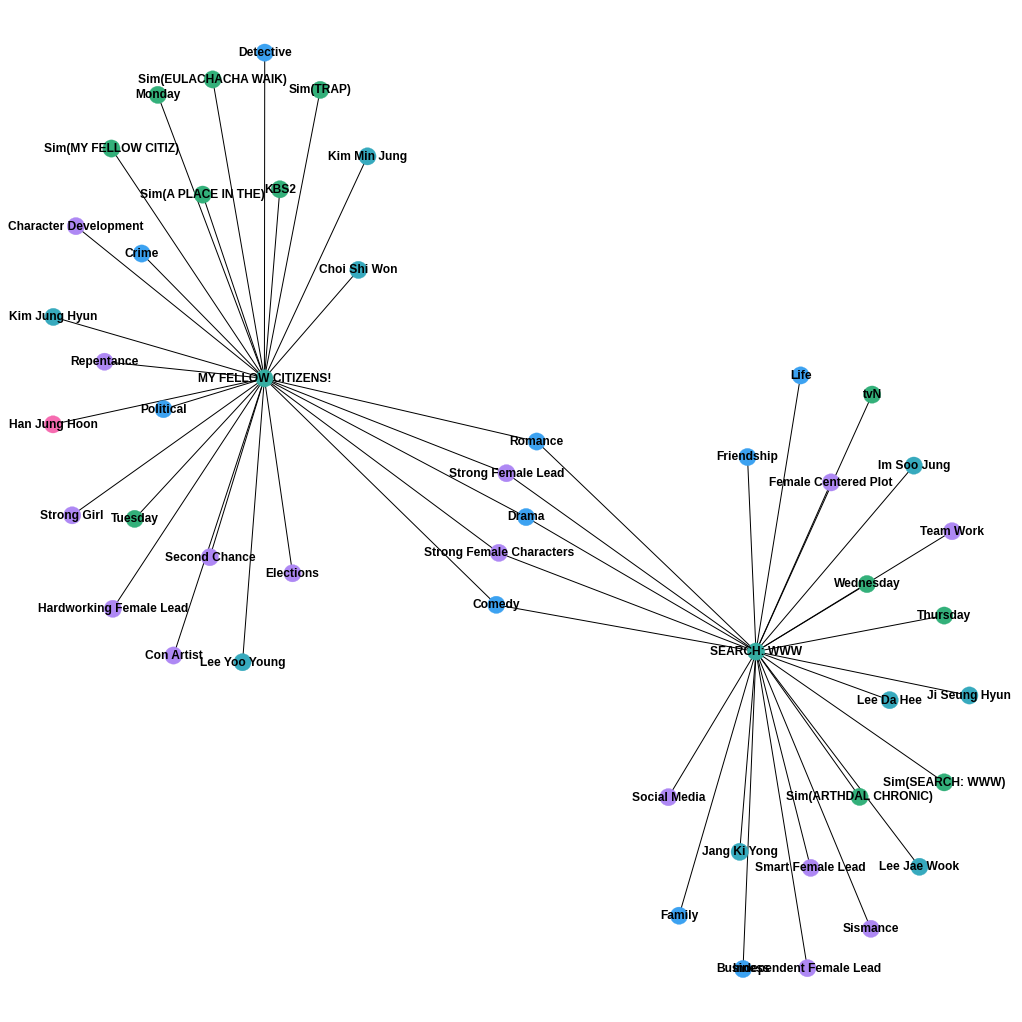

In [157]:
list_in=["Search: WWW","My Fellow Citizens!"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

In [158]:
def get_recommendation(root, commons_dict =dict()):
    root = root.upper()
#     commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="KDRAMA":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : 0})
                else:
                    commons += 1
                    commons_dict.update({e2 : commons})
    
#     sorted_dict = sorted(commons_dict.items(), key=lambda x: x[1], reverse=True)[:10]
#     print_recommendation(sorted_dict, root)
    return commons_dict

def print_recommendation(sorted_dict, root):
    print("="*55)
    print("Recommendation for {}:".format(root))
    print("="*55)
    print("Title"," "*40, "Score")
    for e in sorted_dict:
        name_len = len(e[0])
        print(e[0][:45], " "*(45-name_len), e[1])
    print("="*55)

In [184]:
liked=["SEARCH: WWW","Crash Landing on You","LOVE ALARM", "WHAT'S WRONG WITH SECRETARY KIM", "MY ID IS GANGNAM BEAUTY", "Vagabond", 
       "Weightlifting Fairy Kim Bok Joo", "While You Were Sleeping", "Are You Human Too?", "The K2", "Live Up to Your Name",]
      "Love in the Moonlight", "Shopping King Louie", "Rookie Historian Goo Hae Ryung", "Suits", "Hit the Top", "Hwarang", "Lucky Romance",
      "Hospital Ship", "Descendants of the sun", "man to man"]
disliked=["Mad Dog", "PRISON PLAYBOOK", "ROMANCE IS A BONUS BOOK", 'EXTRAORDINARY YOU', "THE BEAUTY INSIDE", "Signal",
          "Hotel del Luna","When the Camellia Blooms", "Thirty But Seventeen", "Extracurricular", "Switch: Change the World",
          "He is Psychometric", "Suspicious Partner", "Lawless Attorney", "on the way to the airport"]

liked_dict = dict()
disliked_dict = dict()
for dislike in disliked:
    disliked_dict = get_recommendation(dislike, disliked_dict)
for dislike in disliked:
    disliked_dict.update({dislike.upper(): 2000})
for like in liked:
    liked_dict = get_recommendation(like, liked_dict)    

In [185]:
for name, score in liked_dict.items():
    minus = disliked_dict.get(name)
    if(minus != None ):
        net = score - minus
        liked_dict.update({name: net})
for like in liked:
    del(liked_dict[like.upper()])
sorted_dict = sorted(liked_dict.items(), key=lambda x: x[1], reverse=True)[:10]
print_recommendation(sorted_dict, " and ".join(liked))

Recommendation for SEARCH: WWW and Crash Landing on You and LOVE ALARM and WHAT'S WRONG WITH SECRETARY KIM and MY ID IS GANGNAM BEAUTY and Vagabond and Weightlifting Fairy Kim Bok Joo and While You Were Sleeping and Are You Human Too? and The K2 and Live Up to Your Name:
Title                                          Score
ONE-DIMENSIONAL                                6
WILD GUYS                                      6
A GUY FRIEND 14 DAYS BEFORE                    6
SIMPLE RELATABLE DRAMA                         5
DANCE NO.15                                    5
AS YOUR HEART TELLS                            5
YOUR IMAGINATION BECOMES REALITY               5
DATING CLASS                                   4
FARMING ACADEMY                                4
UNWRAP THE AGE OF 13                           4


In [161]:
list_in=["Search: WWW","Crash Landing on You","My Fellow Citizens!"]
get_recommendation(list_in[2])

{'EULACHACHA WAIKIKI': 6,
 'EULACHACHA WAIKIKI 2': 6,
 'POSITIVE PHYSIQUE': 4,
 'WHEN THE CAMELLIA BLOOMS': 5,
 'CRUSHES REVERSE': 1,
 'TO YOU WHO BEGINS TO LOVE': 3,
 'UNCONTROLLABLY FOND': 4,
 'PLEASE COME BACK, MISTER': 4,
 '109 STRANGE THINGS': 1,
 'TRAP': 3,
 'LET ME INTRODUCE HER': 1,
 'JEALOUSY INCARNATE': 2,
 'CHILDREN OF NOBODY': 4,
 'RICKETY RACKETY FAMILY': 2,
 'REVOLUTIONARY LOVE': 3,
 'TUNNEL': 3,
 'YOUR HONOR': 3,
 'THE LIES WITHIN': 2,
 'MR. SUNSHINE': 2,
 'MAN TO MAN': 1,
 'HOSPITAL PLAYLIST': 3,
 'PRISON PLAYBOOK': 2,
 'CRASH LANDING ON YOU': 5,
 'GOBLIN': 1,
 'LIFE ON MARS': 3,
 'WEIGHTLIFTING FAIRY KIM BOK JOO': 1,
 'CHICAGO TYPEWRITER': 5,
 'THE FIERY PRIEST': 3,
 'WHILE YOU WERE SLEEPING': 3,
 'HOTEL DEL LUNA': 4,
 'DESCENDANTS OF THE SUN': 4,
 'AVENGERS SOCIAL CLUB': 3,
 'STRONG WOMAN DO BONG SOON': 4,
 'AGE OF YOUTH': 4,
 'MY FATHER IS STRANGE': 4,
 'CHIEF KIM': 5,
 'GO BACK COUPLE': 3,
 'BECAUSE THIS IS MY FIRST LIFE': 3,
 'BE MELODRAMATIC': 2,
 'SEARCH: WWW': 4

## PROBLEM
1. Insufficient adjacent nodes
2. Multiple drama (like and dislike)
3. Drama with less degree has lower chance 